In [ ]:
# !pip install transformers accelerate datasets git+https://github.com/huggingface/diffusers Pillow==9.4.0 torchmetrics wandb

In [ ]:
from local_secrets import hf_token, wandb_key
from huggingface_hub import login
import wandb

login(token=hf_token)
wandb.login(key=wandb_key)

In [ ]:
import torch, torch.nn.functional as F, random, wandb, time
import torchvision.transforms as T
from diffusers import AutoencoderDC, SanaTransformer2DModel
from diffusers.schedulers import FlowMatchEulerDiscreteScheduler
from transformers import AutoModel, AutoTokenizer, set_seed
from datasets import load_dataset, Dataset, DatasetDict
from tqdm import tqdm

from utils import PIL_to_latent, latent_to_PIL, make_grid, encode_prompt, dcae_scalingf, pil_clipscore

seed = 42
set_seed(seed)

In [4]:
dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

transformer = SanaTransformer2DModel.from_config("transformer_Sana-7L-MBERT_config.json").to(device).to(dtype)
text_encoder = AutoModel.from_pretrained("answerdotai/ModernBERT-base", torch_dtype=dtype).to(device)
tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base", torch_dtype=dtype)

model = "Efficient-Large-Model/Sana_600M_1024px_diffusers"
dcae = AutoencoderDC.from_pretrained(model, subfolder="vae", torch_dtype=dtype).to(device)
scheduler = FlowMatchEulerDiscreteScheduler.from_pretrained(model, subfolder="scheduler")

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'diffusers.models.transformers.sana_transformer.SanaTransformer2DModel'>.load_config(...) followed by <class 'diffusers.models.transformers.sana_transformer.SanaTransformer2DModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
Process ForkProcess-10:
Process ForkProcess-1:
Process ForkProcess-2:
Process ForkProcess-28:
Process ForkProcess-29:
Process ForkProcess-8:
Process ForkProcess-6:
Process ForkProcess-30:
Process ForkProcess-19:
Process ForkProcess-18:
Process ForkProcess-9:
Process ForkProcess-17:
Process ForkProcess-20:
Process ForkProcess-22:
Process ForkProcess-25:
Traceback 

# Load dataset

In [5]:
from utils import load_imagenet_labels

ds = load_dataset("g-ronimo/Imagenet-256-latents_dc-ae-f32c32-sana-1.0")
labels = load_imagenet_labels()
labels_encoded={i: encode_prompt(labels[i], tokenizer, text_encoder) for i in tqdm(range(len(labels)))}

len(labels_encoded), len(labels_encoded[0]), labels_encoded[0][0].shape, labels_encoded[0][1].shape

Resolving data files:   0%|          | 0/31 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/31 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
100%|██████████| 1000/1000 [00:42<00:00, 23.57it/s]


(1000, 2, torch.Size([1, 300, 768]), torch.Size([1, 300]))

In [6]:
from torch.utils.data import DataLoader

def collate(items):
    labels = [i["label"] for i in items]
    latents = torch.stack([torch.Tensor(i["latent"]) for i in items]).to(dtype).to(device)
    prompts_encoded = torch.cat([labels_encoded[label][0] for label in labels])
    prompts_atnmask = torch.cat([labels_encoded[label][1] for label in labels])

    return labels, latents, prompts_encoded, prompts_atnmask

dataloader = DataLoader(ds["train"], batch_size=2, shuffle=True, generator = torch.manual_seed(seed), collate_fn=collate)
labels, latents, prompts_encoded, prompts_atnmask = next(iter(dataloader))
len(labels), latents.mean(), latents.shape, prompts_encoded.shape, prompts_atnmask.shape

(2,
 tensor(0.1787, device='cuda:0', dtype=torch.bfloat16),
 torch.Size([2, 32, 8, 8]),
 torch.Size([2, 300, 768]),
 torch.Size([2, 300]))

# Helpers for eval and generate

In [7]:
scheduler.set_timesteps(100)

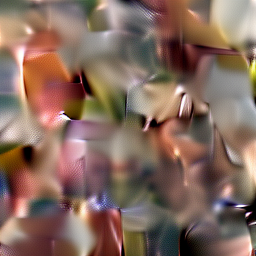

In [8]:
def generate(prompt, latent_dim=[1, 32, 8, 8], latent_seed=42):
    scheduler.set_timesteps(scheduler.timesteps.size(0))     # reset step index
    prompt_encoded, prompt_atnmask = encode_prompt(prompt, tokenizer, text_encoder)
    latents = torch.randn(latent_dim, generator = torch.manual_seed(latent_seed)).to(dtype).to(device)

    for t_idx in range(scheduler.timesteps.size(0)):
        t = scheduler.timesteps[t_idx].unsqueeze(0).to(device)
        with torch.no_grad():
            noise_pred = transformer(latents, encoder_hidden_states=prompt_encoded, timestep=t, encoder_attention_mask=prompt_atnmask, return_dict=False)[0]
        latents = scheduler.step(noise_pred, t, latents, return_dict=False)[0]
    return latent_to_PIL(latents / dcae_scalingf, dcae)

generate("0")

In [9]:
def eval_loss(data_val, num_samples=10, batch_size=24):
    losses = []
    eval_dataloader = iter(DataLoader(data_val, batch_size=batch_size, shuffle=False, collate_fn=collate))
    
    for i in tqdm(range(num_samples), "eval_loss"):
        label, latent, prompt_encoded, prompt_atnmask = next(eval_dataloader)
        noise = torch.randn_like(latent)
        timestep = scheduler.timesteps[torch.randint(scheduler.timesteps.size(0),(latent.shape[0],))].to(device)
        latent_noisy = scheduler.scale_noise(latent, timestep, noise)
        with torch.no_grad():
            noise_pred = transformer(latent_noisy, encoder_hidden_states = prompt_encoded, encoder_attention_mask = prompt_atnmask, timestep = timestep, return_dict=False)[0]
        loss = F.mse_loss(noise_pred, noise - latent)
        losses.append(loss.item())
    return sum(losses)/len(losses)

eval_loss(ds["train"])

eval_loss: 100%|██████████| 10/10 [00:00<00:00, 20.75it/s]


6.175

# Train

In [15]:
log_wandb = True
lr = 5e-4
# bs = 128
bs = 320
epochs = 200
timesteps_training = 1000
timesteps_generate = 1000
steps_log, steps_eval = 20, 400
prompts_eval = load_imagenet_labels()[:10]

splits = ["train", "val"]
data_train, data_val = ds[splits[0]], ds[splits[1]]

steps_epoch = len(data_train) // bs

dataloader = DataLoader(data_train, batch_size=bs, shuffle=True, generator = torch.manual_seed(seed), collate_fn=collate)
optimizer = torch.optim.AdamW(transformer.parameters(), lr=lr)
scheduler.set_timesteps(timesteps_training)

model_size = sum(p.numel() for p in transformer.parameters() if p.requires_grad)
print(f"Model parameters: {model_size / 1e6:.2f}M")
print(f"{len(splits)} splits: {splits}", [len(ds[s]) for s in splits])
print("Eval prompts: ", prompts_eval)
assert len(splits)==2 

Model parameters: 156.41M
2 splits: ['train', 'val'] [1281167, 50000]
Eval prompts:  ['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead shark', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich']


In [16]:
if log_wandb: 
    if wandb.run is not None: wandb.finish()
    wandb.init(project="Hana", name=f"Z-{model_size / 1e6:.2f}M_FMNIST_LR-{lr}_BS-{bs}_TS-{timesteps_training}_runpod4090").log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb") or path.endswith(".json"))

step = 0
last_step_time = time.time()

for _ in range(epochs):
    for labels, latents, prompts_encoded, prompts_atnmask in dataloader:        
        noise = torch.randn_like(latents)
        timesteps = scheduler.timesteps[torch.randint(timesteps_training,(latents.shape[0],))].to(device)
        latents_noisy = scheduler.scale_noise(latents, timesteps, noise)        
        noise_pred = transformer(latents_noisy, prompts_encoded, timesteps, prompts_atnmask).sample
    
        loss = F.mse_loss(noise_pred, noise - latents)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(transformer.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()        
        
        if step > 0 and step % steps_log == 0:
            loss_train = loss.item()
            step_time = (time.time() - last_step_time) / steps_log * 1000
            sample_tp = bs * steps_log / (time.time() - last_step_time)
            print(f"step {step}, epoch: {step / steps_epoch:.4f}, train loss: {loss_train:.4f}, grad_norm: {grad_norm:.2f}, {step_time:.2f}ms/step, {sample_tp:.2f}samples/sec")
            if log_wandb: wandb.log({"loss_train": loss_train, "grad_norm": grad_norm, "step_time": step_time, "step": step, "sample_tp": sample_tp, "sample_count": step * bs, "epoch": step / steps_epoch})
            last_step_time = time.time()
    
        if step % steps_eval == 0:
            transformer.eval()
            loss_eval = eval_loss(data_val)
            scheduler.set_timesteps(timesteps_generate)
            images_eval = [generate(p) for p in tqdm(prompts_eval, "eval_images")]
            clipscore = pil_clipscore(images_eval, prompts_eval)
            print(f"step {step}, eval loss: {loss_eval:.4f}, clipscore: {clipscore:.2f}")
            if log_wandb: wandb.log({"loss_eval": loss_eval, "clipscore": clipscore, "images_eval": wandb.Image(make_grid(images_eval, 2, 5)), "step": step, "sample_count": step * bs, "epoch": step / steps_epoch})
            transformer.train()
            scheduler.set_timesteps(timesteps_training)
        step += 1

eval_images: 100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


step 0, eval loss: 10.8375, clipscore: 23.77
step 2, epoch: 0.0005, train loss: 7.8438, grad_norm: 15.31, 8360.55ms/step, 38.27samples/sec
step 4, epoch: 0.0010, train loss: 5.5000, grad_norm: 6.47, 1036.61ms/step, 308.70samples/sec
step 6, epoch: 0.0015, train loss: 5.1250, grad_norm: 2.61, 1037.95ms/step, 308.30samples/sec
step 8, epoch: 0.0020, train loss: 4.8125, grad_norm: 1.98, 1034.26ms/step, 309.40samples/sec
step 10, epoch: 0.0025, train loss: 4.6250, grad_norm: 2.20, 1039.00ms/step, 307.99samples/sec


eval_images: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


step 10, eval loss: 4.3531, clipscore: 22.29
step 12, epoch: 0.0030, train loss: 4.5312, grad_norm: 1.94, 7510.28ms/step, 42.61samples/sec
step 14, epoch: 0.0035, train loss: 4.4375, grad_norm: 1.42, 1033.98ms/step, 309.48samples/sec
step 16, epoch: 0.0040, train loss: 4.4375, grad_norm: 1.49, 1033.96ms/step, 309.49samples/sec
step 18, epoch: 0.0045, train loss: 4.0625, grad_norm: 1.79, 1036.73ms/step, 308.66samples/sec
step 20, epoch: 0.0050, train loss: 4.0312, grad_norm: 2.14, 1032.38ms/step, 309.96samples/sec


eval_images:  10%|█         | 1/10 [00:00<00:08,  1.09it/s]

KeyboardInterrupt: 

In [ ]:
transformer.push_to_hub(f"g-ronimo/hana-small_alpha9-IN_TS-{timesteps_training}_{epochs}e")

In [ ]:
!runpodctl remove pod $RUNPOD_POD_ID